# Phase Locking Value Matrix

In [1]:
import numpy as np
import pandas as pd
from numba import jit
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import hilbert

from get_iEEG_data import *
from iEEG_helper_functions import *

In [2]:
def create_pwd_file(username, password, fname=None):
    if fname is None:
        fname = "{}_ieeglogin.bin".format(username[:3])
    with open(fname, "wb") as f:
        f.write(password.encode())
    print("-- -- IEEG password file saved -- --")


create_pwd_file("dma", "mycqEv-pevfo4-roqfan")

with open("dma_ieeglogin.bin", "r") as f:
    s = Session("dma", f.read())

ds = s.open_dataset("HUP210_phaseII")
all_channel_labels = np.array(ds.get_channel_labels())
label_idxs = electrode_selection(all_channel_labels)
labels = all_channel_labels[label_idxs]

-- -- IEEG password file saved -- --


In [3]:
ieeg_data, fs = get_iEEG_data(
    "dma",
    "dma_ieeglogin.bin",
    "HUP210_phaseII",
    (179677 + 20) * 1e6,
    (179677 + 40) * 1e6,
    labels,
)

fs = int(fs)

In [4]:
good_channels_res = detect_bad_channels_optimized(ieeg_data.to_numpy(), fs)
good_channel_indicies = good_channels_res[0]
good_channel_labels = labels[good_channel_indicies]
ieeg_data = ieeg_data[good_channel_labels].to_numpy()

ieeg_data = common_average_montage(ieeg_data)

# Apply the filters directly on the DataFrame
ieeg_data = notch_filter(ieeg_data, 59, 61, fs)
ieeg_data = bandpass_filter(ieeg_data, 1, 70, fs)

In [5]:
def calculate_synchrony(time_series):
    """
    Calculate the Kuramoto order parameter for a set of time series
    Args:
        time_series (np.array): 2D array where each row is a time series
    Returns:
        np.array: Kuramoto order parameter for each time point
    """
    # Extract the number of time series and the number of time points
    N, _ = time_series.shape
    # Apply the Hilbert Transform to get an analytical signal
    analytical_signals = hilbert(time_series)
    assert analytical_signals.shape == time_series.shape
    # Extract the instantaneous phase for each time series using np.angle
    phases = np.angle(analytical_signals, deg=False)
    assert phases.shape == time_series.shape
    # Compute the Kuramoto order parameter for each time point
    # 1j*1j == -1
    r_t = np.abs(np.sum(np.exp(1j * phases), axis=0)) / N
    R = np.mean(r_t)
    return r_t, R


def calculate_plv_matrix(wins):
    """
    Args:
        wins (numpy array): wins is a numpy array (n_ch, n_samples)
    """
    # get analytic signal
    analytic_signal = hilbert(wins, axis=1)  # Axis is 1 now as it's 2D array

    # get angle
    angle = np.angle(analytic_signal)

    # take difference of angles between pairs of channels
    angle_diff = angle[:, None, :] - angle[None, :, :]  # (n_ch, n_ch, n_samples)
    angle_diff = np.exp(
        1j * angle_diff
    )  # Move exp calculation here to avoid another pass later

    plv_matrix = np.abs(np.mean(angle_diff, axis=2))  # Average over time samples

    return plv_matrix

In [6]:
input_array = ieeg_data.T

In [7]:
r_t, R = calculate_synchrony(input_array)

In [8]:
plv_matrix = calculate_plv_matrix(input_array)
assert plv_matrix.shape == (len(input_array), len(input_array))

In [9]:
plv_matrix.shape

(190, 190)

In [10]:
# Average everything in plv_matrix
plv_matrix_avg = np.mean(plv_matrix)
plv_matrix_avg

0.1986905342571127

<Axes: >

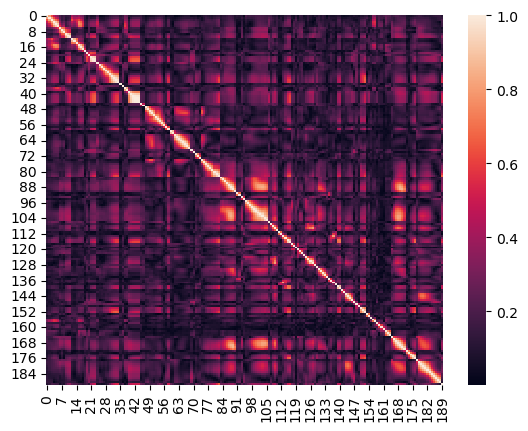

In [11]:
sns.heatmap(plv_matrix)

In [12]:
@jit(nopython=True)
def compute_plv(angle):
    n_ch, n_samples = angle.shape
    plv = np.zeros((n_ch, n_ch))

    for i in range(n_ch):
        for j in range(n_ch):
            complex_sum = 0.0
            for t in range(n_samples):
                complex_sum += np.exp(1j * (angle[i, t] - angle[j, t]))
            plv[i, j] = abs(complex_sum) / n_samples
    return plv


def calculate_plv_matrix_optimized(wins):
    """
    Args:
        wins (numpy array): wins is a numpy array (n_ch, n_samples)
    """
    # get analytic signal
    analytic_signal = hilbert(wins, axis=1)
    # get angle
    angle = np.angle(analytic_signal)
    # calculate PLV using numba optimized function
    plv = compute_plv(angle)

    return plv

In [13]:
plv_matrix_optimized = calculate_plv_matrix_optimized(input_array)
assert plv_matrix_optimized.shape == (len(input_array), len(input_array))

<Axes: >

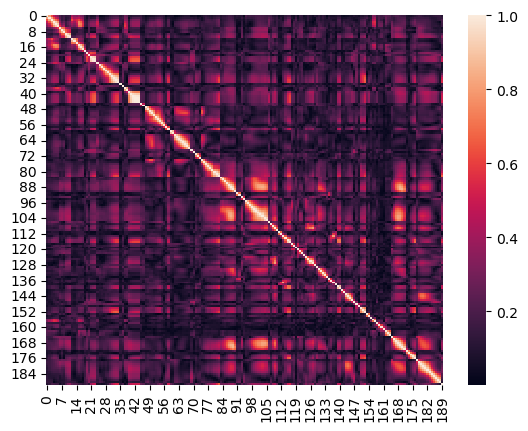

In [14]:
sns.heatmap(plv_matrix_optimized)

In [15]:
# Assert if plv_matrix_optimized and plv_matrix are the same
assert np.allclose(plv_matrix_optimized, plv_matrix)

<Axes: >

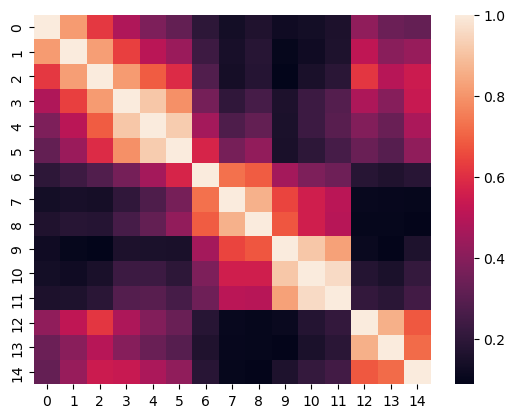

In [22]:
sns.heatmap(plv_matrix_optimized[:15, :15])